In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn

df = pd.read_csv('data/heart_failure_clinical_records_dataset.csv')

df.info()

In [73]:
target = df['DEATH_EVENT']
df = df.drop('DEATH_EVENT', axis=1)

scaler = StandardScaler()
df = scaler.fit_transform(df)

df

array([[ 1.19294523e+00, -8.71104775e-01,  1.65728387e-04, ...,
         7.35688190e-01, -6.87681906e-01, -1.62950241e+00],
       [-4.91279276e-01, -8.71104775e-01,  7.51463953e+00, ...,
         7.35688190e-01, -6.87681906e-01, -1.60369074e+00],
       [ 3.50832977e-01, -8.71104775e-01, -4.49938761e-01, ...,
         7.35688190e-01,  1.45416070e+00, -1.59078490e+00],
       ...,
       [-1.33339153e+00, -8.71104775e-01,  1.52597865e+00, ...,
        -1.35927151e+00, -6.87681906e-01,  1.90669738e+00],
       [-1.33339153e+00, -8.71104775e-01,  1.89039811e+00, ...,
         7.35688190e-01,  1.45416070e+00,  1.93250906e+00],
       [-9.12335403e-01, -8.71104775e-01, -3.98321274e-01, ...,
         7.35688190e-01,  1.45416070e+00,  1.99703825e+00]])

In [74]:
class MLP(nn.Module):
    def __init__(
            self,
            n_inputs: int,
            n_connections: int,
            n_layers: int,
            n_outputs: int,
            xavier: bool = False,
            batch_norm: bool = False
    ):
        super(MLP, self).__init__()
        layers = []
        for i in range(n_layers):
            if i == 0:
                layer = nn.Linear(n_inputs, n_connections)
                if xavier:
                    nn.init.xavier_uniform_(layer.weight)
                layers.append(layer)
                if batch_norm:
                    layers.append(nn.BatchNorm1d(n_connections))
                layers.append(nn.ReLU())
            elif i == n_layers - 1:
                layer = nn.Linear(n_connections, n_outputs)
                if xavier:
                    nn.init.xavier_uniform_(layer.weight)
                layers.append(layer)
                if batch_norm:
                    layers.append(nn.BatchNorm1d(n_outputs))
                layers.append(nn.Sigmoid())
            else:
                layer = nn.Linear(n_connections, n_connections)
                if xavier:
                    nn.init.xavier_uniform_(layer.weight)
                layers.append(layer)
                if batch_norm:
                    layers.append(nn.BatchNorm1d(n_connections))
                layers.append(nn.ReLU())
        self.fc = nn.Sequential(*layers)
        self.double()

    def forward(self, x):
        return self.fc(x)

n_features = df.shape[1]
n_classes = len(np.unique(target))

n_features, n_classes

(12, 2)

In [75]:
from torch.utils.data import DataLoader

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

X_train, X_test, y_train, y_test = train_test_split(df, target.values, train_size=0.7)

X_train = torch.tensor(X_train, dtype=torch.float64, device=device)
X_test = torch.tensor(X_test, dtype=torch.float64, device=device)
y_train = torch.tensor(y_train, dtype=torch.long, device=device)
y_test = torch.tensor(y_test, dtype=torch.long, device=device)

train = list(zip(X_train, y_train))
test = list(zip(X_test, y_test))

batch_size = 50
train_loader = DataLoader(train, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test, batch_size=batch_size, shuffle=False)

next(iter(train_loader))

[tensor([[-2.3865e-01, -8.7110e-01, -4.6439e-01,  1.1798e+00, -7.0768e-03,
           1.3593e+00, -1.0608e-01, -3.8138e-01,  5.3905e-01,  7.3569e-01,
          -6.8768e-01,  1.2872e+00],
         [-7.0223e-02,  1.1480e+00, -3.6219e-01,  1.1798e+00, -1.1074e+00,
          -7.3569e-01, -7.1034e-01,  2.9640e-01,  7.6606e-01,  7.3569e-01,
          -6.8768e-01, -1.3243e-01],
         [-4.9128e-01, -8.7110e-01, -5.3872e-01, -8.4758e-01, -2.6099e-01,
          -7.3569e-01, -3.6212e-01, -1.8773e-01, -3.6899e-01,  7.3569e-01,
           1.4542e+00, -5.1960e-01],
         [-7.0223e-02, -8.7110e-01,  1.3567e+00,  1.1798e+00, -1.1074e+00,
          -7.3569e-01,  1.0410e+00,  6.8371e-01,  1.6741e+00, -1.3593e+00,
          -6.8768e-01,  5.3868e-01],
         [-1.5860e+00, -8.7110e-01,  4.7768e+00, -8.4758e-01, -6.8418e-01,
          -7.3569e-01, -3.8261e-01, -3.8138e-01,  7.6606e-01,  7.3569e-01,
           1.4542e+00, -5.5832e-01],
         [-1.5860e+00,  1.1480e+00, -5.1188e-01, -8.4758e-01, -2.

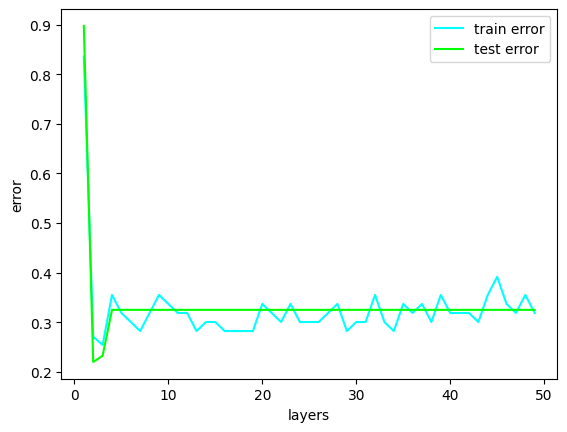

In [76]:
import torch.optim as optim
import matplotlib.pyplot as plt

def error(outputs, labels):
    predictions = torch.argmax(outputs, dim=1)
    correct = (predictions == labels).sum()
    return 1 - correct / len(labels)

def train_model(model: nn.Module, epochs: int = 5):
    model = model.to(device)
    criterion = nn.CrossEntropyLoss()
    gd = optim.Adam(model.parameters(), lr=1e-3)

    for epoch in range(epochs):
        model.train()
        for i, (inputs, labels) in enumerate(train_loader):
            inputs = inputs.to(device)
            labels = labels.to(device)
            gd.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            gd.step()

    model.eval()
    train_errors = []
    test_errors = []

    with torch.no_grad():

        for inputs, labels in train_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)
            train_errors.append(error(outputs, labels))

        for inputs, labels in test_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)
            test_errors.append(error(outputs, labels))

    return np.mean(np.array(train_errors)), np.mean(np.array(test_errors))

def plot_model_error(model_class, xavier, batch_norm):
    errors = [
        train_model(
            model_class(
                n_inputs=n_features,
                n_connections=20,
                n_layers=n_layers,
                n_outputs=n_classes,
                xavier=xavier,
                batch_norm=batch_norm
            ), epochs=10
        ) for n_layers in range(1, 50)
    ]
    train_err, test_err = list(zip(*errors))
    plt.plot(range(1, 50), train_err, c='cyan', label='train error')
    plt.plot(range(1, 50), test_err, c='lime', label='test error')
    plt.xlabel('layers')
    plt.ylabel('error')
    plt.legend()
    plt.show()

plot_model_error(MLP, xavier=False, batch_norm=False)

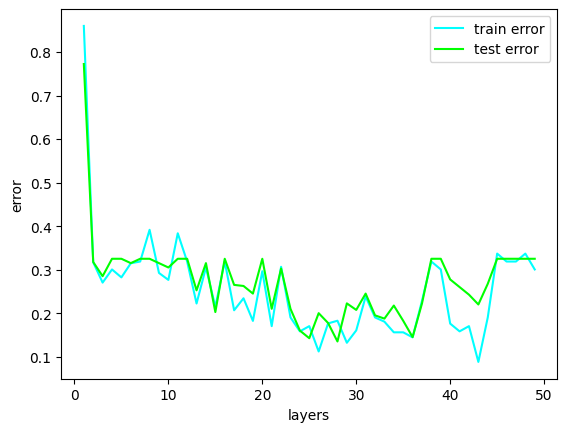

In [77]:
class ResBlock(nn.Module):
    def __init__(self, n_inputs: int, n_connections: int, n_outputs: int, xavier: bool = False, batch_norm: bool = False):
        super(ResBlock, self).__init__()
        self.fc1 = nn.Linear(n_inputs, n_connections)
        self.bn1 = nn.BatchNorm1d(n_connections)
        self.fc1_act = nn.ReLU()
        self.fc2 = nn.Linear(n_connections, n_outputs)
        self.bn2 = nn.BatchNorm1d(n_outputs)
        self.fc2_act = nn.ReLU()
        self.batch_norm = batch_norm

        if xavier:
            nn.init.xavier_uniform_(self.fc1.weight)
            nn.init.xavier_uniform_(self.fc2.weight)

    def forward(self, x):
        prev_x = x
        x = self.fc1(x)
        if self.batch_norm:
            x = self.bn1(x)
        x = self.fc1_act(x)
        x = self.fc2(x)
        if self.batch_norm:
            x = self.bn2(x)
        return self.fc2_act(x + prev_x)

class ResNet(nn.Module):
    def __init__(
            self,
            n_inputs: int,
            n_connections: int,
            n_layers: int,
            n_outputs: int,
            xavier: bool = False,
            batch_norm: bool = False
    ):
        super(ResNet, self).__init__()
        layers = []
        for i in range(n_layers):
            if i == 0:
                layer = nn.Linear(n_inputs, n_connections)
                if xavier:
                    nn.init.xavier_uniform_(layer.weight)
                layers.append(layer)
                if batch_norm:
                    layers.append(nn.BatchNorm1d(n_connections))
                layers.append(nn.ReLU())
            elif i == n_layers - 1:
                layer = nn.Linear(n_connections, n_outputs)
                if xavier:
                    nn.init.xavier_uniform_(layer.weight)
                layers.append(layer)
                if batch_norm:
                    layers.append(nn.BatchNorm1d(n_outputs))
                layers.append(nn.Sigmoid())
            else:
                layers.append(ResBlock(n_connections, n_connections, n_connections, xavier=xavier, batch_norm=batch_norm))
        self.resnet = nn.Sequential(*layers)
        self.double()

    def forward(self, x):
        return self.resnet(x)

plot_model_error(ResNet, xavier=False, batch_norm=False)

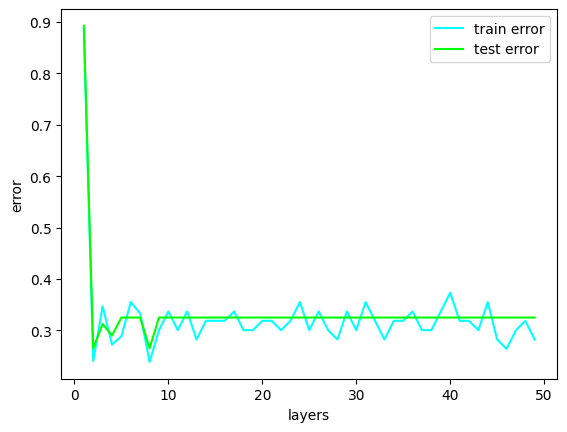

In [78]:
plot_model_error(MLP, xavier=True, batch_norm=False)

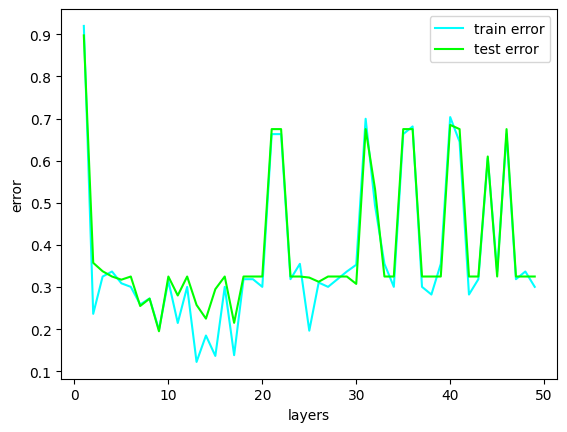

In [79]:
plot_model_error(ResNet, xavier=True, batch_norm=False)

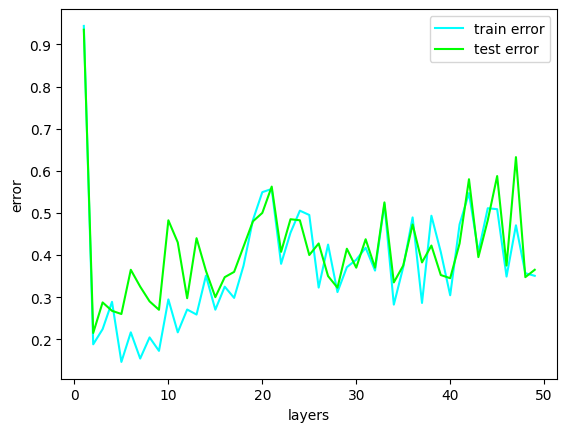

In [80]:
plot_model_error(MLP, xavier=False, batch_norm=True)

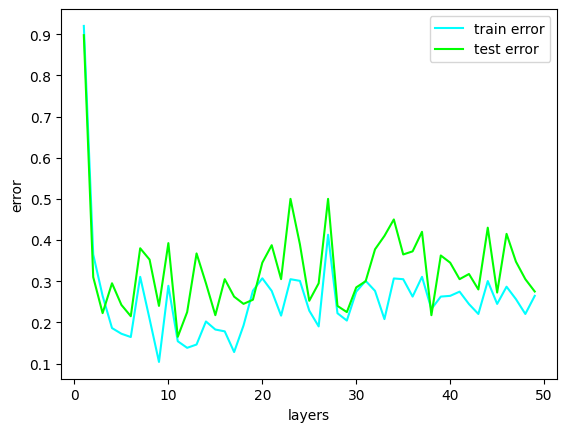

In [81]:
plot_model_error(ResNet, xavier=False, batch_norm=True)

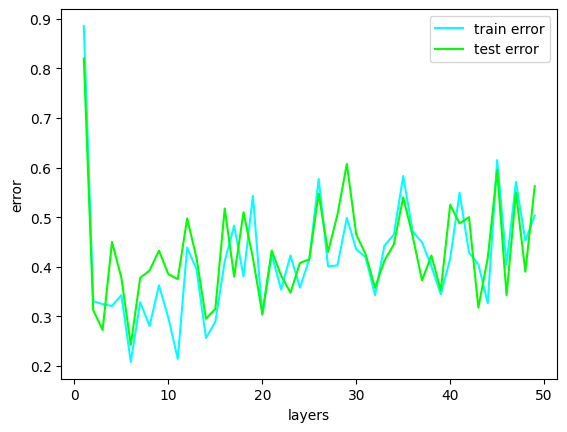

In [82]:
plot_model_error(MLP, xavier=True, batch_norm=True)

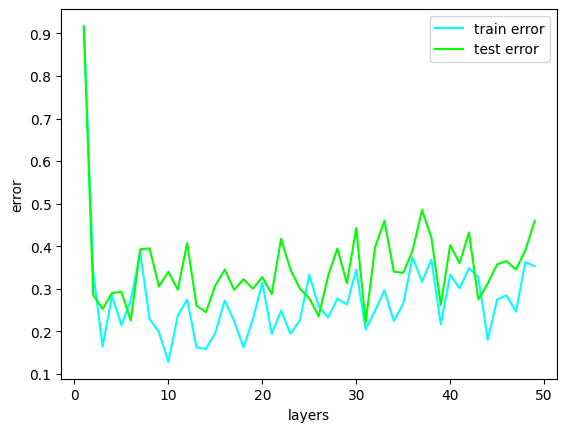

In [83]:
plot_model_error(ResNet, xavier=True, batch_norm=True)